In [ ]:
!pip install transformers torch streamlit matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
incident_text = """
On June 5, 2024, Unit 3 experienced a temporary loss of power due to a failed generator control module.
Operators responded immediately and shifted cooling operations to backup systems.
No radiation was released. The NRC was notified, and full power was restored within 3 hours.
Investigation revealed that the failure was due to aged circuit components.
"""


In [ ]:
summary = summarizer(incident_text, max_length=100, min_length=30, do_sample=False)
print(summary[0]['summary_text'])

Your max_length is set to 100, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)


 Unit 3 experienced a temporary loss of power due to a failed generator control module . Operators responded immediately and shifted cooling operations to backup systems . Full power was restored within 3 hours .


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained(
    "facebook/bart-large-cnn",
    attn_implementation="eager"
)


In [ ]:
incident_text = """
On June 5, 2024, Unit 3 experienced a temporary loss of power due to a failed generator control module.
Operators responded immediately and shifted cooling operations to backup systems.
No radiation was released. The NRC was notified, and full power was restored within 3 hours.
Investigation revealed that the failure was due to aged circuit components.
"""

inputs = tokenizer(incident_text, return_tensors="pt", truncation=True, max_length=1024)
output = model.generate(
    **inputs,
    max_length=50,
    min_length=20,
    num_beams=4,
    early_stopping=True,
    output_attentions=True,
    return_dict_in_generate=True
)

In [ ]:
summary_text = tokenizer.decode(output['sequences'][0], skip_special_tokens=True)
print("Summary:", summary_text)

Summary: On June 5, 2024, Unit 3 experienced a temporary loss of power due to a failed generator control module. No radiation was released. Investigation revealed that the failure was due to aged circuit components.


In [ ]:
# Cross-attention from last decoder layer (list: layers → batch → heads → target → source)
cross_attn = output.cross_attentions[-1][0]  # shape: [num_heads, target_len, source_len]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Average across heads and target tokens
avg_attn = cross_attn.mean(dim=0).mean(dim=0).detach().numpy().flatten() # shape: [source_len]
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

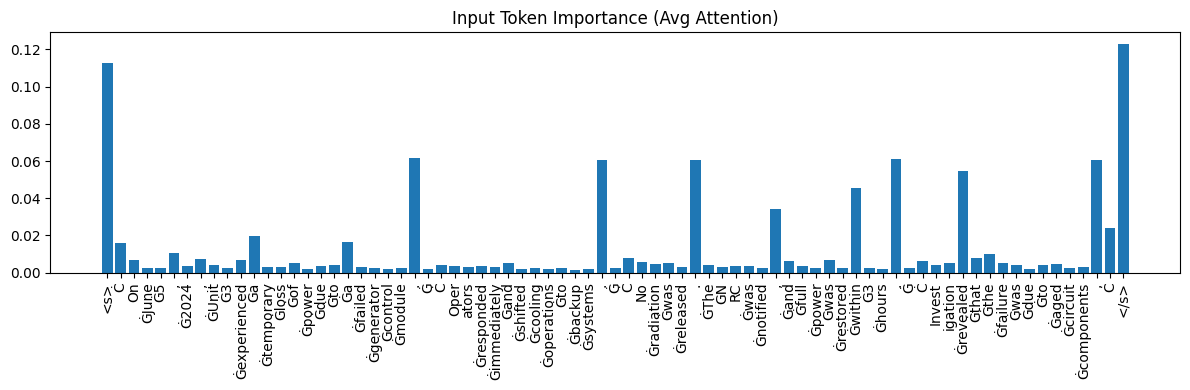

In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(range(len(tokens)), avg_attn)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title("Input Token Importance (Avg Attention)")
plt.tight_layout()
plt.show()